<a href="https://colab.research.google.com/github/Abhinavk910/Natural-Language-Processing/blob/master/Sentiment_analysis_of_Movie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files
files.upload()

! pip install -q kaggle
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [0]:
! kaggle competitions download -c sentiment-analysis-on-movie-reviews

  0% 0.00/471k [00:00<?, ?B/s]
100% 471k/471k [00:00<00:00, 54.7MB/s]
  0% 0.00/583k [00:00<?, ?B/s]
100% 583k/583k [00:00<00:00, 37.8MB/s]
  0% 0.00/1.21M [00:00<?, ?B/s]
100% 1.21M/1.21M [00:00<00:00, 80.7MB/s]


In [0]:
! kaggle datasets download -d terenceliu4444/glove6b100dtxt

 91% 120M/131M [00:01<00:00, 92.8MB/s]
100% 131M/131M [00:01<00:00, 123MB/s] 


  0% 0.00/2.55k [00:00<?, ?B/s]
100% 2.55k/2.55k [00:00<00:00, 2.35MB/s]


In [0]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
import numpy as np
from matplotlib import pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import nltk
from nltk.tokenize import TreebankWordTokenizer
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM,  Dropout, Conv1D, MaxPooling1D, Dropout #Activation
from keras.layers import Embedding
from keras.callbacks import ModelCheckpoint
  

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
!unzip -q "train.tsv.zip"

In [0]:
data = pd.read_csv('train.tsv', sep='\t')
data.head(2)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,2


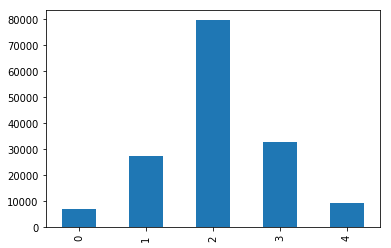

In [0]:
data['Sentiment'].value_counts(sort = False).plot(kind = 'bar')

In [0]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords =  set(stopwords.words('english'))
len(stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


179

In [0]:
! unzip -q 'excessive-stopword.zip'

In [0]:
stopwords =set(w.lower().strip() for w in open("stopwords.txt"))
stopwords.add(".")
stopwords.add(",")
len(stopwords)

722

In [0]:
def stopwordcount(x):
    tokens = x.lower().split(" ")
    stopword = [token for token in tokens if token in stopwords]
    return len(stopword)/len(tokens)
  
tokenizer_treebank = TreebankWordTokenizer()
lemma = WordNetLemmatizer()
def forming(x):
    x = x.lower()
    tokens = tokenizer_treebank.tokenize(x)
    tokens = [token for token in tokens if token not in stopwords]
    tokens = [lemma.lemmatize(token) for token in tokens]
    sent = (" ").join(tokens)
    return sent
  


In [0]:
data['length'] = data.Phrase.apply(lambda x: len(x.split(" ")))
data['sw_per_phrase'] = data.Phrase.apply(lambda x: stopwordcount(x))
data['tokenize'] = data.Phrase.apply(lambda x:forming(x))
data['length_after'] = data.apply(lambda x: len(x.tokenize.split(" ")) if x.sw_per_phrase != 1 else 0, axis = 1)
data.head(2)

,PhraseId,SentenceId,Phrase,Sentiment,length,sw_per_phrase,tokenize,length_after
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1,37,0.729730,series escapade demonstrating adage goose gander occasionally amuses amount story,10
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,2,14,0.642857,series escapade demonstrating adage goose,5


In [0]:
! unzip -q 'test.tsv.zip'

In [0]:
data_test = pd.read_csv('test.tsv', sep = '\t')
data_test['length'] = data_test.Phrase.apply(lambda x: len(x.split(" ")))
data_test['sw_per_phrase'] = data_test.Phrase.apply(lambda x: stopwordcount(x))
data_test['tokenize'] = data_test.Phrase.apply(lambda x:forming(x))
data_test['length_after'] = data_test.apply(lambda x: len(x.tokenize.split(" ")) if x.sw_per_phrase != 1 else 0, axis = 1)
data_test.head(2)

,PhraseId,SentenceId,Phrase,length,sw_per_phrase,tokenize,length_after
0,156061,8545,An intermittently pleasing but mostly routine effort .,8,0.500000,intermittently pleasing routine effort,4
1,156062,8545,An intermittently pleasing but mostly routine effort,7,0.428571,intermittently pleasing routine effort,4


In [0]:
!unzip -q 'glove6b100dtxt.zip'

In [0]:
word2vec = {}

with open('glove.6B.100d.txt') as f:
    for line in f:
        values = line.split(" ")
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
        embedding.append(vec)
print('Found %s word vectors.' % len(word2vec))

Found 400000 word vectors.
Shape of embedding 400000 x 100


!**Glove with RNN**

In [0]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['tokenize'])
sequences = tokenizer.texts_to_sequences(data['tokenize'])
sequences[0:2]

[[147, 6163, 5362, 5873, 2516, 9751, 420, 9044, 421, 6],
 [147, 6163, 5362, 5873, 2516]]

In [0]:
vocab_len = len(tokenizer.word_counts)+1

In [0]:
Maxlen = max([len(w) for w in sequences])
Maxlen_test = max([len(w.split()) for w in data_test.tokenize])
Maxlen, Maxlen_test

(28, 24)

In [0]:
from keras.preprocessing.sequence import pad_sequences
data_target = pad_sequences(sequences, maxlen=Maxlen, padding = 'post')

In [0]:
sequences_test = tokenizer.texts_to_sequences(data_test['tokenize'])
data_test_target = pad_sequences(sequences_test, maxlen = 28, padding = 'post')

In [0]:
embedding_matrix = np.zeros((vocab_len, 100))
for word, index in tokenizer.word_index.items():
  embedding_vector = word2vec.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector 

In [0]:
embedding_matrix.shape

(13657, 100)

In [0]:
model = Sequential()
model.add(Embedding(vocab_len, 100, input_length=Maxlen, weights = [embedding_matrix], trainable = False))
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(100,recurrent_dropout=0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 28, 100)           1365700   
_________________________________________________________________
dropout_12 (Dropout)         (None, 28, 100)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 24, 64)            32064     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 6, 64)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_11 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_13 (Dropout)         (None, 100)               0         
__________

In [0]:
# define the checkpoint
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
model.fit(data_target, data.Sentiment, validation_split=0.4, epochs = 10, batch_size = 256)


Train on 93636 samples, validate on 62424 samples
Epoch 1/10
93636/93636 [==============================] - 31s 331us/step - loss: 1.0157 - acc: 0.5928 - val_loss: 1.0282 - val_acc: 0.5800
Epoch 2/10
93636/93636 [==============================] - 31s 331us/step - loss: 0.9834 - acc: 0.6039 - val_loss: 1.0266 - val_acc: 0.5797
Epoch 3/10
93636/93636 [==============================] - 31s 333us/step - loss: 0.9596 - acc: 0.6136 - val_loss: 1.0322 - val_acc: 0.5789
Epoch 4/10
93636/93636 [==============================] - 31s 331us/step - loss: 0.9401 - acc: 0.6199 - val_loss: 1.0401 - val_acc: 0.5804
Epoch 5/10
93636/93636 [==============================] - 31s 330us/step - loss: 0.9231 - acc: 0.6293 - val_loss: 1.0458 - val_acc: 0.5768
Epoch 6/10
93636/93636 [==============================] - 31s 329us/step - loss: 0.9098 - acc: 0.6345 - val_loss: 1.0525 - val_acc: 0.5792
Epoch 7/10
93636/93636 [==============================] - 31s 328us/step - loss: 0.9017 - acc: 0.6363 - val_loss: 1.

In [0]:
y_pred = model.predict_classes(data_test_target)

In [0]:
sub = pd.read_csv('sampleSubmission.csv')
sub.Sentiment = y_pred
sub.to_csv('rnn1.csv', index=False)

In [0]:
y_pred2 = model3.predict_classes(data_test_target_extra)

In [0]:
sub = pd.read_csv('sampleSubmission.csv')
sub.Sentiment = y_pred2
sub.to_csv('rnn3.csv', index=False)

In [0]:
extra = np.array(data.iloc[:,[4,5,7]].values)
extra_test = np.array(data_test.iloc[:,[3,4,6]].values)

In [0]:
data_target_extra = np.concatenate([data_target, extra], axis = 1)
data_test_target_extra = np.concatenate([data_test_target, extra_test], axis = 1)

In [0]:
model3 = Sequential()
model3.add(Embedding(vocab_len+3, 100, input_length=31))
model3.add(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
model3.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model3.add(Dense(100, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(5, activation='softmax'))
model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.fit(data_target_extra, data.Sentiment, batch_size=256, epochs=10, verbose=1, validation_split=0.4)

Train on 93636 samples, validate on 62424 samples
Epoch 1/10
93636/93636 [==============================] - 171s 2ms/step - loss: 1.2468 - acc: 0.5161 - val_loss: 1.2384 - val_acc: 0.4996
Epoch 2/10
93636/93636 [==============================] - 167s 2ms/step - loss: 1.1579 - acc: 0.5437 - val_loss: 1.1739 - val_acc: 0.5253
Epoch 3/10
93636/93636 [==============================] - 167s 2ms/step - loss: 1.0830 - acc: 0.5781 - val_loss: 1.1563 - val_acc: 0.5363
Epoch 4/10
93636/93636 [==============================] - 167s 2ms/step - loss: 1.0149 - acc: 0.6104 - val_loss: 1.1435 - val_acc: 0.5593
Epoch 5/10
93636/93636 [==============================] - 167s 2ms/step - loss: 0.9344 - acc: 0.6402 - val_loss: 1.1167 - val_acc: 0.5700
Epoch 6/10
93636/93636 [==============================] - 166s 2ms/step - loss: 0.8877 - acc: 0.6563 - val_loss: 1.0814 - val_acc: 0.5767
Epoch 7/10
93636/93636 [==============================] - 168s 2ms/step - loss: 0.8552 - acc: 0.6664 - val_loss: 1.0983 - 

In [0]:
y_pred = model3.predict_classes(data_test_target_extra)
sub = pd.read_csv('sampleSubmission.csv')
sub.Sentiment = y_pred
sub.to_csv('rnn3.csv', index=False)

**Glove with Logistic Regression**

In [0]:
def change(content):
  X = np.zeros([len(content), D])
  emptycount = 0
  n = 0
  for sentence in content:
      vecs = []
      tokens = sentence.lower().split()
      for token in tokens:
          if token in word2vec:
              vec = word2vec[token]
              vecs.append(vec)
      if len(vecs) > 0:
          vecs = np.array(vecs)
          X[n] = np.mean(vecs, axis = 0)
      else:
          emptycount += 1
      n += 1

  print('No. of samples whoese word not fount is %s / %s' % (emptycount, len(content)))
  return X

In [0]:
X = change(data.tokenize)
X.shape

No. of samples whoese word not fount is 7222 / 156060


(156060, 50)

In [0]:
extra = np.array(data.iloc[:,[4,5,7]].values)
extra.shape

(156060, 3)

In [0]:
X_train = np.concatenate([X, extra], axis = 1)
X_train.shape

(156060, 53)

In [0]:
y = data.iloc[:,3]
y.shape

(156060,)

In [0]:
X_test = change(data_test.tokenize)
X_test.shape

No. of samples whoese word not fount is 3649 / 66292


(66292, 50)

In [0]:
extra = np.array(data_test.iloc[:,[3,4,6]].values)
extra.shape

(66292, 3)

In [0]:
X_test = np.concatenate([X_test, extra], axis = 1)
X_test.shape

(66292, 53)

In [0]:
def check(model):
    skf = StratifiedKFold(n_splits=5, shuffle = True , random_state=42)
    return cross_val_score(model, X_train, y, scoring = 'accuracy', cv = skf).mean()

In [0]:
from sklearn.linear_model import LogisticRegression
modellor = LogisticRegression()
print('Accuracy Score for LogisticRegression :-',check(modellor))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the 

In [0]:
from sklearn.linear_model import LogisticRegression
modellornewton = LogisticRegression(solver='newton-cg')
print('Accuracy Score for LogisticRegression :-',check(modellornewton))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linea

Accuracy Score for LogisticRegression :- 0.5496348022787498


In [0]:
from sklearn.linear_model import LogisticRegression
modellorsaga = LogisticRegression(solver='saga')
print('Accuracy Score for LogisticRegression :-',check(modellorsaga))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_clas

Accuracy Score for LogisticRegression :- 0.5494746031699075


In [0]:
sub = pd.read_csv('sampleSubmission.csv')
sub.Sentiment = modellornewton.fit(X_train, y).predict(X_test)
sub.to_csv('finallornewton_cg.csv', index=False)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
